In [51]:
import cv2
import numpy as np 
import math
import matplotlib.pyplot as plt 
import matplotlib


def mask_color(frame, color, min_edge_threshold=100, max_edge_threshold=200):
    '''
    Makes a color mask for two colors
    Applies the mask to the image
    1) Returns the masked image
    2) Returns the edges of the image
    '''

    white = [[220,220,220],[255,255,255]]
    # Trial for HSV coding (doesn't work right now)
    orange = [[2, 50, 100], [15, 180, 255]]
    # orange = [[210, 140, 100], [240, 200, 180]]

    if color=='white':

        lower = np.array(white[0])
        upper = np.array(white[1])

    elif color=='orange':
        lower = np.array(orange[0])
        upper = np.array(orange[1])

    mask = cv2.inRange(frame, lower ,upper)
    output = cv2.bitwise_and(frame, frame, mask = mask)

    edges = cv2.Canny(output, min_edge_threshold, max_edge_threshold)
    # cv2.imwrite('images.jpg', output)

    return output, edges



#  
def region_of_interest(edges):

    '''
    Crops the image in the region of interest
    Returns the edges of the cropped image
    '''

    height, width = edges.shape
    mask = np.zeros_like(edges)


    # Make a rectangle to mask the region of interest in the image
    # In this case it masks out the bottom 2/5 part of the image with width equal to the image width
    rect_mask = np.array([[
        (0, height * 1.8 / 5),
        (width, height * 1.8 / 5),
        (width, height * 3 / 5),
        (0, height * 3 / 5),
    ]], np.int32)
    

    # Fill the masked part of the image with black color 
    cv2.fillPoly(mask, rect_mask, 255)

    # Find the edges of the cropped image
    cropped_edges = cv2.bitwise_and(edges, mask)

    return cropped_edges



def detect_line_segments(cropped_edges, rho=5, angle=np.pi / 180, min_threshold=5, minLineLength=8, maxLineGap=4):
    '''
    Returns the line segments calculated by an edges image 
    (In our case it is the edges of the cropped image)
    '''

    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength, maxLineGap)

    return line_segments



def make_points(frame, line):
    '''
    Returns a list of the beginning and end points of the line segments
    '''

    height, width, _ = frame.shape
    slope, intercept = line
    # Make points between the 4/5 the 2/5 of the height of the image 
    y1 = int(height * 4 / 5)  
    y2 = int(y1 * 1 / 2)  
    if slope != 0 :
    # bound the coordinates within the frame
        x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
        x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    if slope ==0 : 
        slope = 0.01
        x1 = 0
        x2 = 0
    return [[x1, y1, x2, y2]]



def lane_lines_calculation(frame, line_segments):
    '''
    Returns the lane lines from combining line segments
                            ---Note---
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    '''
    lane_lines = []
    if line_segments is None:
        print ('No line segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    
    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                # print ('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    if left_fit != None:
        left_fit_average = np.average(left_fit, axis=0)
        if len(left_fit) > 0:
            lane_lines.append(make_points(frame, left_fit_average))
    if right_fit != None:
        right_fit_average = np.average(right_fit, axis=0)
        if len(right_fit) > 0:
            lane_lines.append(make_points(frame, right_fit_average))

    return lane_lines



def steering_angle_calculation(lane_lines, edges):
    '''
    Returns the steering angle from the beginning and endpoints of the lane lines

    If there is only one lane the steering angle is essentially the same as the 
    slope of the single detected lane line
    '''

    height, width= edges.shape
    if len(lane_lines)==2:
        _, _, left_x2, _ = lane_lines[0][0]
        _, _, right_x2, _ = lane_lines[1][0]
        mid = int(width / 2)
        x_offset = (left_x2 + right_x2) / 2 - mid
        y_offset = int(height / 2)

    if len(lane_lines)==1:
        x1, _, x2, _ = lane_lines[0][0]
        x_offset = x2 - x1
        y_offset = int(height / 2)

    if len(lane_lines) == 0:
        x_offset = 1.
        y_offset = np.pi / 4.

    if x_offset == 0:
        angle_to_mid_radian = 0

    if x_offset != 0:
        angle_to_mid_radian = math.atan(y_offset / x_offset)  # angle (in radian) to center vertical line

    angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi)  # angle (in degrees) to center vertical line
    steering_angle = angle_to_mid_deg   # this is the steering angle needed by picar front wheel


   


    return steering_angle





def load_image(path, convert=True):
    img_bgr = cv2.imread(path)
    if convert:
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    else:
        img = img_bgr
    return img






def Power_Change(steering_angle):
    distance_between_opposite_wheels = 14.5 /100 #m
    diameter_of_wheel = 6.5/100 #m
    intergration_time = 350/1000 #sec, TBD

    velocity_change = distance_between_opposite_wheels * np.abs(steering_angle) / diameter_of_wheel / intergration_time / 3
    w = 3 * diameter_of_wheel * velocity_change / distance_between_opposite_wheels
    dw = w * distance_between_opposite_wheels / 6
    power_ratio = 1 - dw/200

    return power_ratio




def display_lines(frame, lines, steering_angle, line_color=(0, 255, 0), steering_line_color=(255, 0, 0), line_width=80):
    '''
    Returns the frame with the lane lines and a line which visulizes the steering angle
    The line which resembles the steering angle always starts at the center bottom of the frame

        ---------------Note--------------- 
            0-89 degree: turn left
            90 degree: going straight
            91-180 degree: turn righ
        ----------------------------------
    '''

    line_image = np.zeros_like(frame)
    line_image2 = np.zeros_like(frame)
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape


    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), steering_line_color, line_width)
    

    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)

    line_image = cv2.addWeighted(frame, 0, line_image, 1, 1)
    steering_angle_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)
    final_image = cv2.addWeighted(line_image, 1, steering_angle_image, 1, 1)
    plt.imshow(final_image)
    return final_image




def auto_guide(frame, show_plot_flag=False, color='orange'):
    
    # img = cv2.cvtColor(frame, cv2.COLOR_B2HSV)
    output, edges = mask_color(frame, color=color, min_edge_threshold=110, max_edge_threshold=330)
    cropped_edges = region_of_interest(edges)
    lane = detect_line_segments(cropped_edges, rho=10, angle=np.pi / 180, min_threshold=5, minLineLength=10, maxLineGap=5)
    lane_lines = lane_lines_calculation(frame, lane)
    steering_angle = steering_angle_calculation(lane_lines, edges) 

    if steering_angle < 0:
        corr_steering_angle = steering_angle + 90
    
    if steering_angle > 0:
        corr_steering_angle = steering_angle - 90
    


    print ('steering angle = ', corr_steering_angle)

    

    if np.abs(corr_steering_angle)  < 10:
        corr_steering_angle = 0
    else:
        pass


    if show_plot_flag:
        display_lines(output, lane_lines, steering_angle, line_width=40)
    else:
        pass


    return corr_steering_angle


steering angle =  -8
0


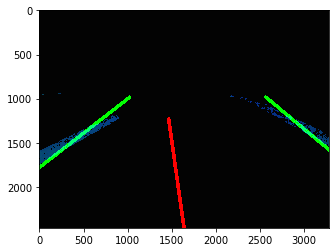

In [52]:
path = '../indoor_new.jpg'
img = load_image(path, convert=True)
steering_angle = auto_guide(img, show_plot_flag=True)
print(steering_angle)


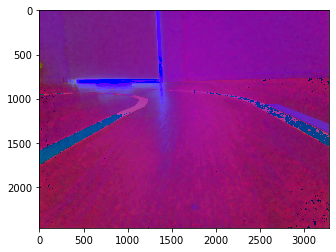

In [23]:
plt.imshow(img)